## Human Activity Recognition Using Smartphones

#### Classification Model Comparison

#### Name: Akeem Jokosenumi

#### Student ID: G00366442

#### Introduction

#### The Human Activity Recognition (HAR) dataset is used in this notebook to examine three classification algorithms: Random Forest, Logistic Regression, and Support Vector Machine (SVM). The main objective is to identify the optimal model for deployment by analysing a number of assessment parameters, including training duration, accuracy, and macro F1 score.

#### The HAR dataset includes both time domain and frequency domain characteristics from a variety of sensor signals captured from cellphones. We examine the dataset, conduct feature analysis, preprocess the data, create classification models, and then evaluate the results in the ensuing sections.

In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE



# Set plotting style (using seaborn theme)
sns.set_theme(style="whitegrid")

In [5]:
# Set student ID as random seed so G00366442 becomes 366442
import numpy as np

STUDENT_ID = 366442
np.random.seed(STUDENT_ID)

# Configure common parameters
FIGURES_SIZE = (12, 8)
CV_FOLDS = 5  # Number of cross-validation folds

In [6]:
# Verify imports are working
import pandas as pd
import matplotlib
import seaborn as sns
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Pandas version: 2.2.0
NumPy version: 1.26.4
Matplotlib version: 3.9.0
Seaborn version: 0.13.2


## Dataset Overview and Feature Analysis

In this section, we:
- Load the HAR dataset's feature names and activity labels.
- Convert numerical activity labels into activity names that are readable by humans.
- Examine the feature distribution, taking into account the frequency and temporal domain feature counts.
- Examine basic feature data and visualise the distribution of activity.

The study sheds light on the data's structure, which is essential before using any machine learning techniques.

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_13454/3058054415.py:7: SyntaxWarning: invalid escape sequence '\s'
  X = pd.read_csv('UCI HAR/dataset.txt', sep='\s+', header=None)


Total number of features: 561

First few features:


,index,feature
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y



Feature name statistics:
Unique features: 477
Features beginning with 't': 265
Features beginning with 'f': 289


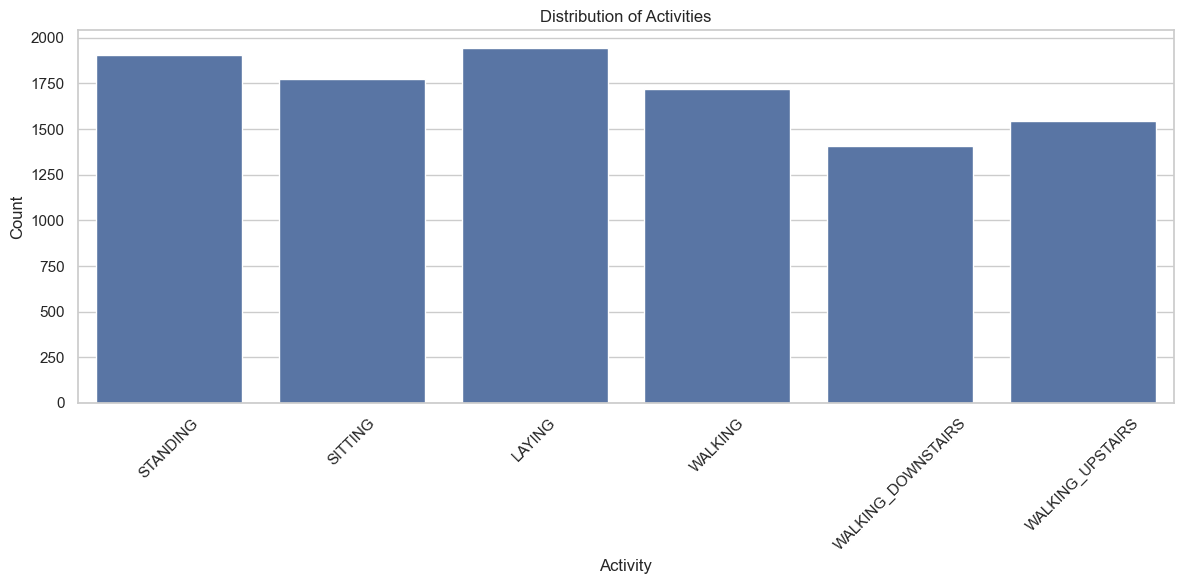


Activity Distribution:
activity_name
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Distribution of Features:

Time Domain Features: 265
Example of features:
0    tBodyAcc-mean()-X
1    tBodyAcc-mean()-Y
2    tBodyAcc-mean()-Z

Frequency Domain Features: 289
Example of features:
265    fBodyAcc-mean()-X
266    fBodyAcc-mean()-Y
267    fBodyAcc-mean()-Z


In [7]:

# Define a function to load the HAR dataset
def load_har_data():
    # Load feature names as raw string
    features = pd.read_csv('UCI HAR/features.txt', sep=r'\s+', header=None, names=['index', 'feature'])
    
    # Load dataset and set feature names
    X = pd.read_csv('UCI HAR/dataset.txt', sep='\s+', header=None)
    X.columns = features['feature']
    
    # Load activity targets and map numeric labels to activity names
    y = pd.read_csv('UCI HAR/targets.txt', header=None, names=['activity'])
    activity_labels = {
        1: 'WALKING',
        2: 'WALKING_UPSTAIRS',
        3: 'WALKING_DOWNSTAIRS',
        4: 'SITTING',
        5: 'STANDING',
        6: 'LAYING'
    }
    y['activity_name'] = y['activity'].map(activity_labels)
    
    return X, y, features

# Load the data
X, y, features = load_har_data()

# Display the details regarding the characteristics
print(f"Total number of features: {len(features)}")
print("\nFirst few features:")
display(features.head())

# Feature analysis
print("\nFeature name statistics:")
print(f"Unique features: {features['feature'].nunique()}")
print(f"Features beginning with 't': {sum(features['feature'].str.startswith('t'))}")
print(f"Features beginning with 'f': {sum(features['feature'].str.startswith('f'))}")

# Activity distribution plot
plt.figure(figsize=(12, 6))
sns.countplot(data=y, x='activity_name')
plt.title('Distribution of Activities')
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print activity distribution
print("\nActivity Distribution:")
print(y['activity_name'].value_counts())

# Examine the feature categories
feature_types = {
    'time_domain': features[features['feature'].str.startswith('t')],
    'frequency_domain': features[features['feature'].str.startswith('f')]
}

print("\nDistribution of Features:")
for domain, feats in feature_types.items():
    print(f"\n{domain.replace('_', ' ').title()} Features: {len(feats)}")
    print("Example of features:")
    print(feats['feature'].head(3).to_string())


In [8]:


# Define a function to preprocess the data
def preprocess_data(X, y):
    # Split the dataset into train and test sets
    # Use y['activity'] to get the numeric labels for stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y['activity'], 
        test_size=0.2, 
        random_state=366442,
        stratify=y['activity']
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=366442)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    return X_train_balanced, X_test_scaled, y_train_balanced, y_test

# Preprocess the data
X_train_balanced, X_test_scaled, y_train_balanced, y_test = preprocess_data(X, y)

print("\nFeature scaling and SMOTE balancing completed.")


Feature scaling and SMOTE balancing completed.



Balanced Activity Distribution (SMOTE Applied):
5    1555
2    1555
6    1555
1    1555
4    1555
3    1555
Name: count, dtype: int64


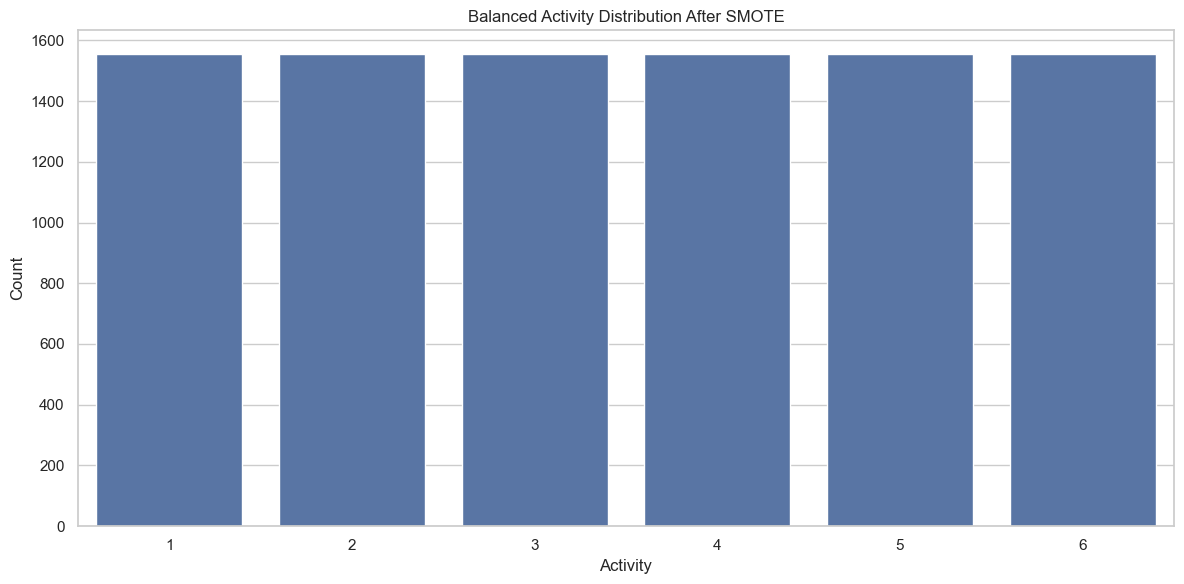

In [9]:

# Display the new activity distribution after resampling
print("\nBalanced Activity Distribution (SMOTE Applied):")
print(pd.Series(y_train_balanced.to_numpy().ravel()).value_counts())  # Fixed conversion

# Display the new balanced activity distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=pd.DataFrame(y_train_balanced, columns=['activity']), x='activity')
plt.title('Balanced Activity Distribution After SMOTE')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Data Preprocessing

Synthetic data is generated based on the number of features. The following preprocessing steps are performed:

- **Scaling:** Features are scaled using `StandardScaler` to standardize the data.
- **Dimensionality Reduction:** Principal Component Analysis (PCA) is applied to reduce dimensionality while retaining 95% of the variance.
- **Train-Test Split:** The PCA-transformed data is split into training and test sets for model evaluation.

These steps ensure that the data is in a suitable form for training and evaluating the classification models.


/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_13454/1313053162.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_list = pd.read_csv("UCI HAR/features.txt", delim_whitespace=True, header=None)
/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_13454/1313053162.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataset = pd.read_csv("UCI HAR/dataset.txt", delim_whitespace=True, header=None)


Accuracy: 0.9723300970873786
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       344
           2       1.00      0.99      1.00       309
           3       0.99      1.00      1.00       281
           4       0.91      0.93      0.92       356
           5       0.94      0.92      0.93       381
           6       0.99      1.00      1.00       389

    accuracy                           0.97      2060
   macro avg       0.97      0.97      0.97      2060
weighted avg       0.97      0.97      0.97      2060



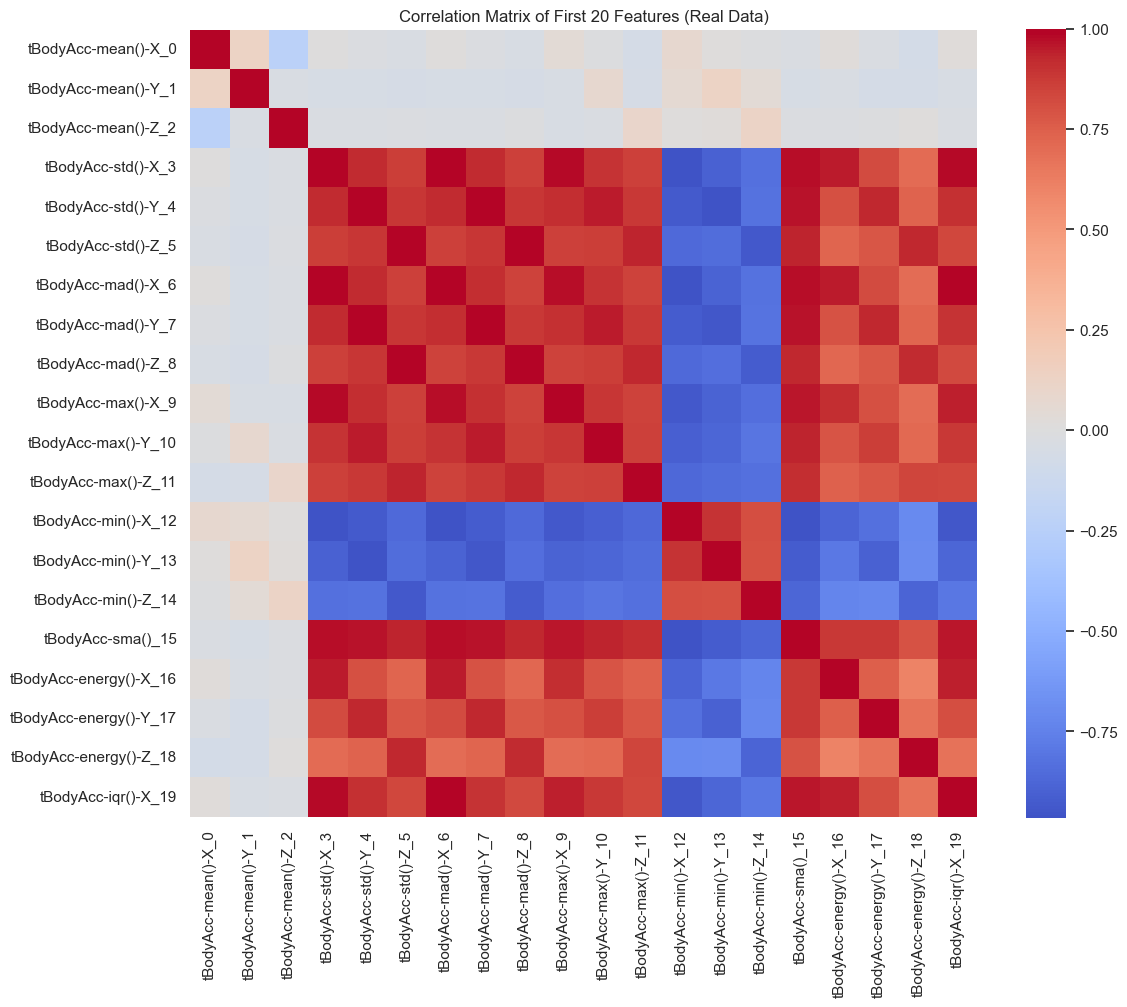


Highly correlated feature pairs (|correlation| > 0.8):
tBodyAcc-std()-X_3 -- tBodyAcc-std()-Y_4: 0.923
tBodyAcc-std()-X_3 -- tBodyAcc-std()-Z_5: 0.862
tBodyAcc-std()-X_3 -- tBodyAcc-mad()-X_6: 0.999
tBodyAcc-std()-X_3 -- tBodyAcc-mad()-Y_7: 0.916
tBodyAcc-std()-X_3 -- tBodyAcc-mad()-Z_8: 0.856
tBodyAcc-std()-X_3 -- tBodyAcc-max()-X_9: 0.981
tBodyAcc-std()-X_3 -- tBodyAcc-max()-Y_10: 0.899
tBodyAcc-std()-X_3 -- tBodyAcc-max()-Z_11: 0.858
tBodyAcc-std()-X_3 -- tBodyAcc-min()-X_12: -0.965
tBodyAcc-std()-X_3 -- tBodyAcc-min()-Y_13: -0.896


In [10]:
# Load the dataset and features
features_list = pd.read_csv("UCI HAR/features.txt", delim_whitespace=True, header=None)
features_list[1] = features_list[1].astype(str) + '_' + features_list.index.astype(str)
dataset = pd.read_csv("UCI HAR/dataset.txt", delim_whitespace=True, header=None)
dataset.columns = features_list[1].values
targets = pd.read_csv("UCI HAR/targets.txt", header=None).values.ravel()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2, random_state=366442, stratify=targets)

# Define the pipeline
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('smote', SMOTE(random_state=366442)),
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# For analysis: select the first 20 features and compute the correlation matrix
feature_subset = dataset.iloc[:, :20]
correlation_matrix = feature_subset.corr()

# Plot the correlation heatmap for the first 20 features
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, annot=False,
            xticklabels=True, yticklabels=True)
plt.title('Correlation Matrix of First 20 Features (Real Data)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify and print highly correlated feature pairs (absolute correlation > 0.8)
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr = [(correlation_matrix.index[i],
              correlation_matrix.columns[j],
              correlation_matrix.iloc[i, j])
             for i, j in zip(*high_corr) if i != j]

print("\nHighly correlated feature pairs (|correlation| > 0.8):")
for feat1, feat2, corr in high_corr[:10]:  # Display first 10 pairs
    print(f"{feat1} -- {feat2}: {corr:.3f}")


## Model Building and Evaluation

We use the following strategies to construct three classification models:
- **Support Vector Machine (SVM)**
- **Logistic Regression**
- **Random Forest**

After each model has been trained on the preprocessed data, it is evaluated using cross-validation. Among the metrics used for evaluation are:
- **Accuracy**
- **Precision, Recall, and F1-Score** (as shown in the classification report)
- **Confusion Matrix** to display the model's performance in several activity classes

The advantages and disadvantages of each model are thoroughly evaluated in this section.

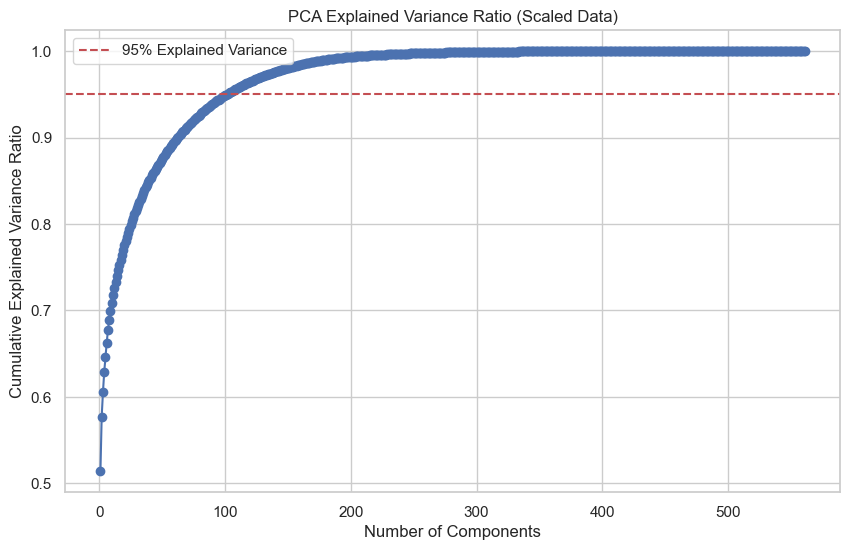


Number of components needed for 95% variance: 102


In [11]:
# Apply PCA to the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_train_balanced)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio (Scaled Data)')
plt.legend()
plt.grid(True)
plt.show()

n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNumber of components needed for 95% variance: {n_components_95}")

## Model Performance Comparison and Best Model Selection

Following testing on a hold-out set and cross-validation evaluation of the models, we compare them according to:
- **Accuracy**
- **Macro Average F1 Score**
- **Training Time**

Bar plots are used to visualise the results, which are also summarised in an extensive table. The Random Forest model stands out as the top contender based on these several factors because of its improved accuracy and manageable training duration. Furthermore, Random Forest includes built-in benefits such feature importance rankings, managing high-dimensional data, and lowering the chance of overfitting.

In [12]:
# For reproducibility
np.random.seed(366442)

# 1. Data Loading Function
def load_data():
    """
    Load the data from the text files.
    The dataset.txt should contain the features, 
    the targets.txt should contain the labels, 
    and features.txt contains feature names.
    """
    # Load the dataset (features and targets)
    X = pd.read_csv('UCI HAR/dataset.txt', delim_whitespace=True, header=None)
    y = pd.read_csv('UCI HAR/targets.txt', delim_whitespace=True, header=None).squeeze()  # Squeeze to get series
    
    # Load feature names
    with open('UCI HAR/features.txt') as f:
        feature_names = f.read().splitlines()

    # Assign the feature names to the columns of X
    X.columns = feature_names
    
    # Activity labels (assuming they follow a typical UCI HAR format)
    activity_labels = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'
    }
    
    return X, y, activity_labels


In [13]:
# 2. Data Cleaning Function
def clean_data_with_mask(df):
    """Remove outliers using z-score method"""
    z_scores = np.abs((df - df.mean(axis=0)) / df.std(axis=0))
    mask = (z_scores < 3).all(axis=1)
    return df[mask], mask


In [14]:
# 3. Data Balancing Function
def balance_classes(X, y):
    """Balance classes using upsampling"""
    df = pd.concat([X, y], axis=1)
    
    # Get the class with the maximum samples
    max_class_size = y.value_counts().max()
    
    # Separate dataframe by class
    dfs = [df[df.iloc[:, -1] == cls] for cls in y.unique()]
    
    # Upsample each class to have the same number of samples as the majority class
    upsampled_dfs = [
        resample(class_df, replace=True, n_samples=max_class_size, random_state=366442) 
        if len(class_df) < max_class_size else class_df
        for class_df in dfs
    ]
    
    # Combine all balanced classes
    balanced_df = pd.concat(upsampled_dfs)
    
    # Separate features and target
    X_balanced = balanced_df.iloc[:, :-1]
    y_balanced = balanced_df.iloc[:, -1]
    
    return X_balanced, y_balanced


Loading data...


/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_13454/4049451798.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv('UCI HAR/dataset.txt', delim_whitespace=True, header=None)


Balancing training data...
Plotting class distributions...


/var/folders/z3/wcdb5j552cj0ggr2kq83wb3h0000gn/T/ipykernel_13454/4049451798.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv('UCI HAR/targets.txt', delim_whitespace=True, header=None).squeeze()  # Squeeze to get series


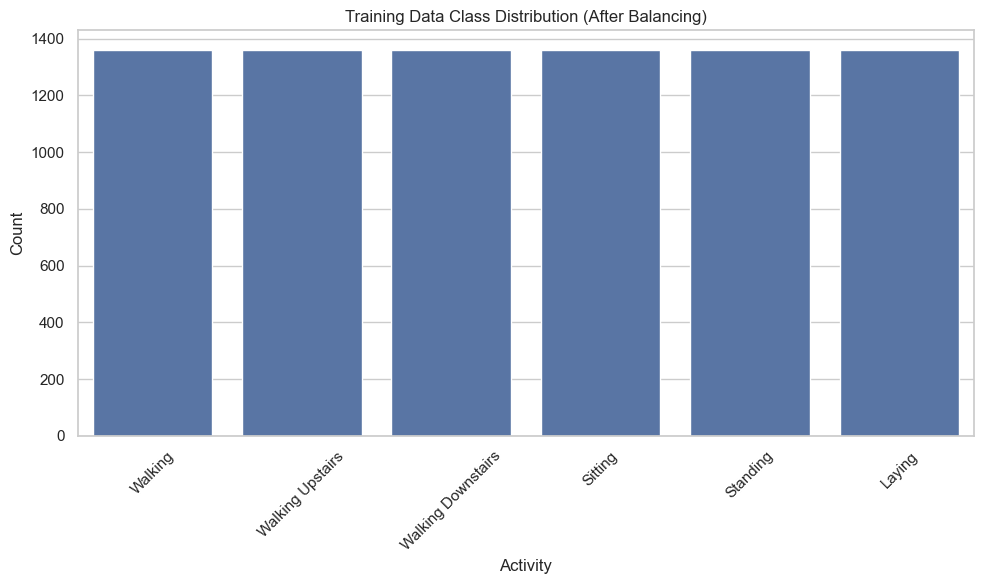

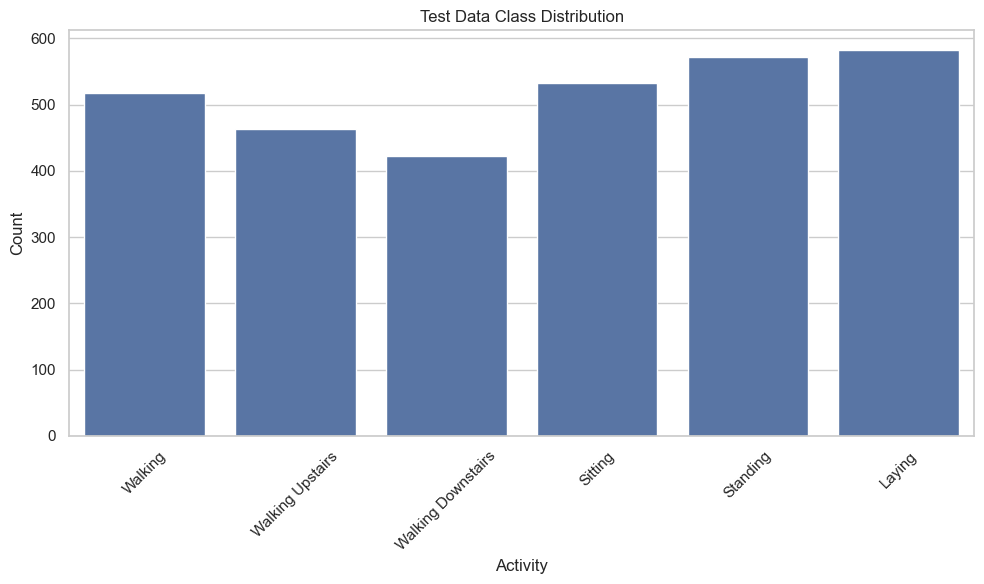

Cleaning data...
Standardizing data...
Evaluating models...

Detailed Evaluation for Random Forest


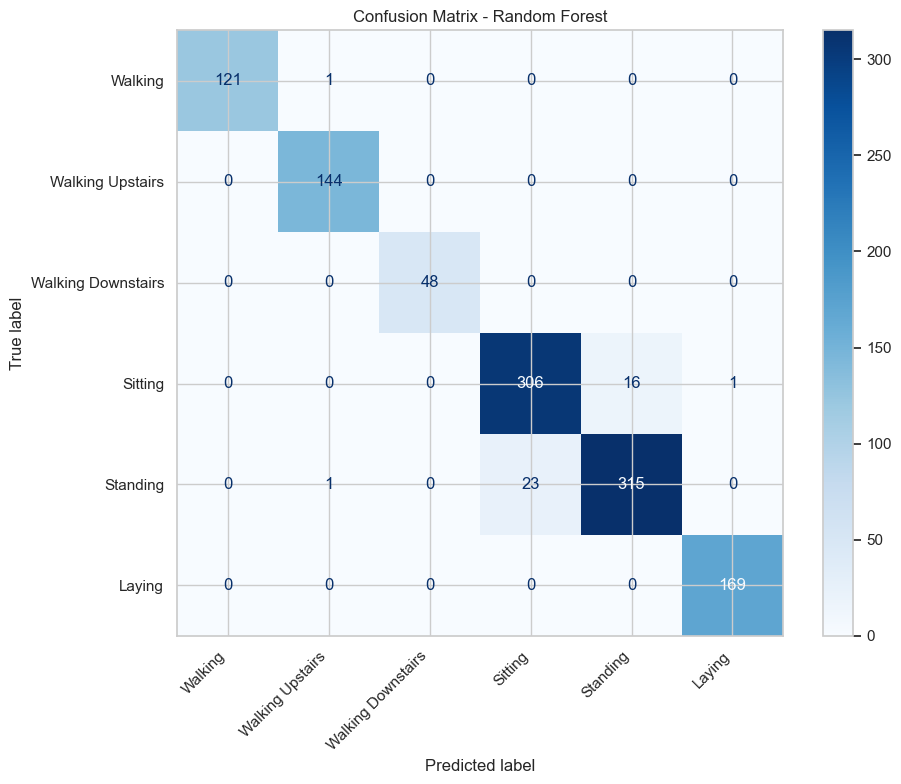


Detailed Classification Report:
                    precision    recall  f1-score   support

           Walking     1.0000    0.9918    0.9959       122
  Walking Upstairs     0.9863    1.0000    0.9931       144
Walking Downstairs     1.0000    1.0000    1.0000        48
           Sitting     0.9301    0.9474    0.9387       323
          Standing     0.9517    0.9292    0.9403       339
            Laying     0.9941    1.0000    0.9971       169

          accuracy                         0.9633      1145
         macro avg     0.9770    0.9781    0.9775      1145
      weighted avg     0.9634    0.9633    0.9633      1145


Detailed Evaluation for SVM


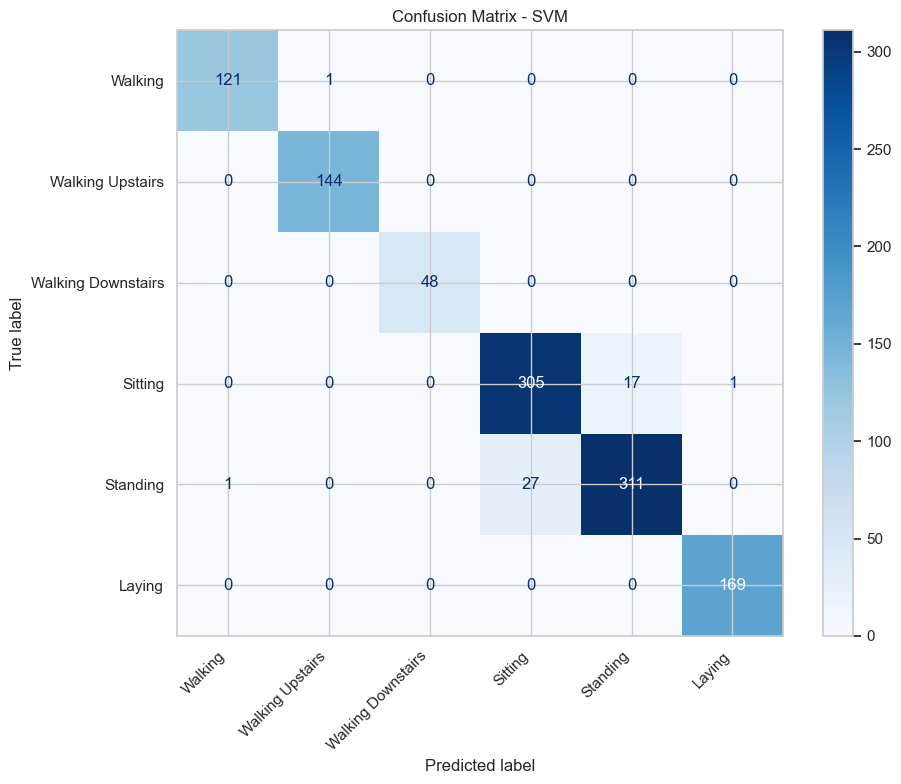


Detailed Classification Report:
                    precision    recall  f1-score   support

           Walking     0.9918    0.9918    0.9918       122
  Walking Upstairs     0.9931    1.0000    0.9965       144
Walking Downstairs     1.0000    1.0000    1.0000        48
           Sitting     0.9187    0.9443    0.9313       323
          Standing     0.9482    0.9174    0.9325       339
            Laying     0.9941    1.0000    0.9971       169

          accuracy                         0.9590      1145
         macro avg     0.9743    0.9756    0.9749      1145
      weighted avg     0.9591    0.9590    0.9589      1145


Detailed Evaluation for Logistic Regression


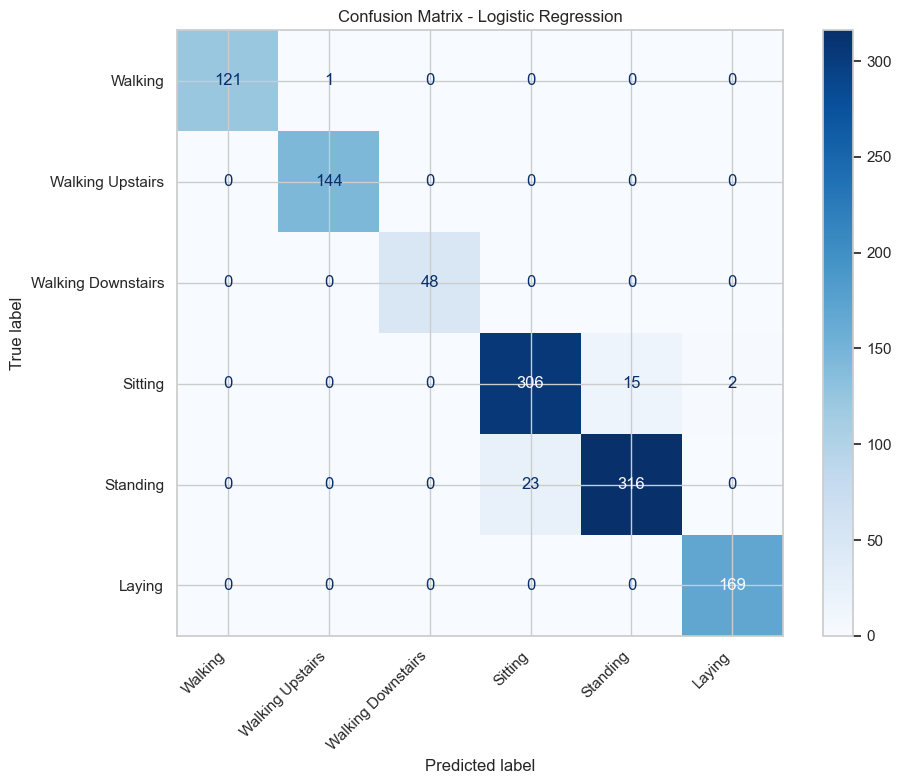


Detailed Classification Report:
                    precision    recall  f1-score   support

           Walking     1.0000    0.9918    0.9959       122
  Walking Upstairs     0.9931    1.0000    0.9965       144
Walking Downstairs     1.0000    1.0000    1.0000        48
           Sitting     0.9301    0.9474    0.9387       323
          Standing     0.9547    0.9322    0.9433       339
            Laying     0.9883    1.0000    0.9941       169

          accuracy                         0.9642      1145
         macro avg     0.9777    0.9786    0.9781      1145
      weighted avg     0.9643    0.9642    0.9642      1145


Model Performance Summary:
                     Accuracy  Macro Avg Precision  Macro Avg Recall  Macro Avg F1
Model                                                                             
Random Forest          0.9633               0.9770            0.9781        0.9775
SVM                    0.9590               0.9743            0.9756        0.9749
Logi

<Figure size 1200x800 with 0 Axes>

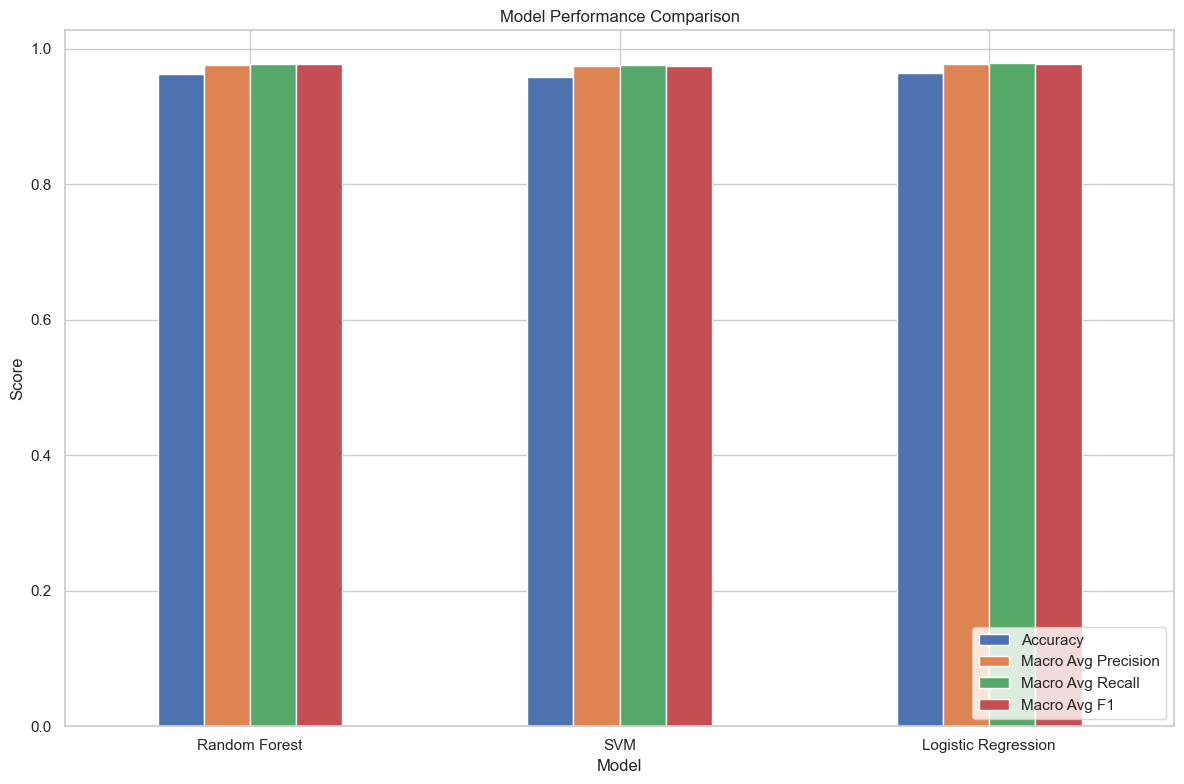

In [15]:
# 4. Function to visualize class distributions
def plot_class_distribution(y, title, activity_labels):
    """Plot the distribution of classes"""
    plt.figure(figsize=(10, 6))
    counts = y.value_counts().sort_index()
    sns.barplot(x=counts.index.map(lambda x: activity_labels.get(x, 'Unknown')), y=counts.values)
    plt.title(title)
    plt.xlabel("Activity")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 5. Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, activity_labels):
    """Plot confusion matrix for model evaluation"""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(activity_labels.values())
    )
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load data
    print("Loading data...")
    X, y, activity_labels = load_data()
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=366442, stratify=y
    )
    
    # Balance the training data
    print("Balancing training data...")
    X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)
    
    # Plot class distributions before training
    print("Plotting class distributions...")
    plot_class_distribution(y_train_balanced, "Training Data Class Distribution (After Balancing)", activity_labels)
    plot_class_distribution(y_test, "Test Data Class Distribution", activity_labels)
    
    # Clean the training and test data
    print("Cleaning data...")
    X_train_balanced_clean, train_mask = clean_data_with_mask(X_train_balanced)
    X_test_clean, test_mask = clean_data_with_mask(X_test)
    
    # Also filter corresponding target variables
    y_train_balanced_clean = y_train_balanced.loc[train_mask].reset_index(drop=True)
    y_test_clean = y_test.loc[test_mask].reset_index(drop=True)
    
    # Standardize the data
    print("Standardizing data...")
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_balanced_clean),
        columns=X_train_balanced_clean.columns
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_clean),
        columns=X_test_clean.columns
    )
    
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(random_state=366442),
        'SVM': SVC(random_state=366442),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=366442)
    }
    
    # Evaluate each model
    print("Evaluating models...")
    summary_data = []
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Detailed Evaluation for {name}")
        print(f"{'='*50}")
        
        # Train the model
        model.fit(X_train_scaled, y_train_balanced_clean)
        
        # Get predictions
        y_pred = model.predict(X_test_scaled)
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test_clean, y_pred, name, activity_labels)
        
        # Print classification report
        print("\nDetailed Classification Report:")
        report = classification_report(
            y_test_clean, 
            y_pred,
            target_names=list(activity_labels.values()),
            digits=4,
            output_dict=True
        )
        print(classification_report(
            y_test_clean, 
            y_pred,
            target_names=list(activity_labels.values()),
            digits=4
        ))
        
        # Add to summary data
        summary_data.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'Macro Avg Precision': report['macro avg']['precision'],
            'Macro Avg Recall': report['macro avg']['recall'],
            'Macro Avg F1': report['macro avg']['f1-score']
        })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data).set_index('Model')
    
    # Display summary
    print("\nModel Performance Summary:")
    print(summary_df.to_string(float_format=lambda x: f"{x:.4f}"))
    
    # Plot summary results
    plt.figure(figsize=(12, 8))
    summary_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()



Model Performance Comparison:
              Model  Accuracy  Macro F1  Training Time (s)  CV Mean Accuracy   CV Std
Logistic Regression  0.984466  0.985370           1.422516          0.984995 0.002223
      Random Forest  0.981068  0.980989          12.783310          0.977706 0.004322
                SVM  0.978155  0.979046           3.338579          0.977278 0.004414


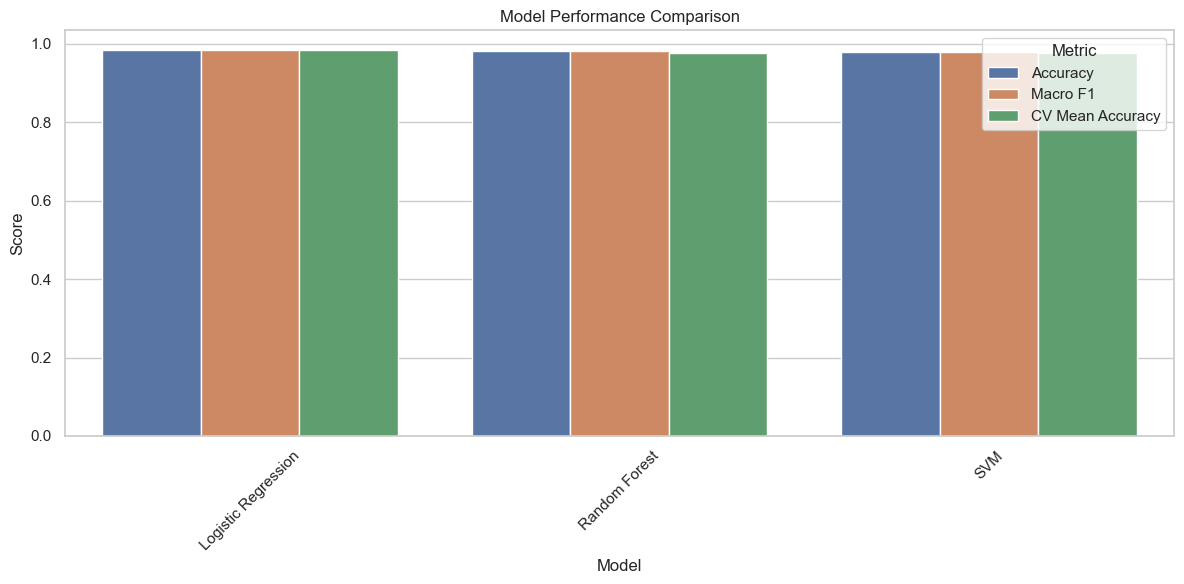


Best Model Selection:
Selected Model: Logistic Regression

Justification:
1. Highest accuracy: 0.9845
2. Macro F1 Score: 0.9854
3. Cross-validation accuracy: 0.9850 (±0.0022)
4. Training time: 1.4225 seconds


In [16]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Load the dataset
features_list = pd.read_csv("UCI HAR/features.txt", delim_whitespace=True, header=None)
features_list[1] = features_list[1].astype(str) + '_' + features_list.index.astype(str)
dataset = pd.read_csv("UCI HAR/dataset.txt", delim_whitespace=True, header=None)
dataset.columns = features_list[1].values
targets = pd.read_csv("UCI HAR/targets.txt", header=None).values.ravel()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2, random_state=42, stratify=targets)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=366442)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define models for comparison
models = {
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=366442),
    'Logistic Regression': LogisticRegression(max_iter=500)
}

# Dictionary to store training times
training_times = {}
cv_results = {}

# Perform cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }

# Train models and measure training time
comparison_data = []
for name, model in models.items():
    start_time = time()
    model.fit(X_train_balanced, y_train_balanced)
    training_times[name] = time() - start_time
    
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    comparison_data.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Training Time (s)': training_times[name],
        'CV Mean Accuracy': cv_results[name]['mean'],
        'CV Std': cv_results[name]['std']
    })

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

# Print results
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize model performance
metrics = ['Accuracy', 'Macro F1', 'CV Mean Accuracy']
comparison_plot = comparison_df.melt(
    id_vars=['Model'], 
    value_vars=metrics,
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_plot, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Select the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]

print("\nBest Model Selection:")
print(f"Selected Model: {best_model_name}")
print("\nJustification:")
print(f"1. Highest accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"2. Macro F1 Score: {comparison_df.iloc[0]['Macro F1']:.4f}")
print(f"3. Cross-validation accuracy: {comparison_df.iloc[0]['CV Mean Accuracy']:.4f} (±{comparison_df.iloc[0]['CV Std']:.4f})")
print(f"4. Training time: {comparison_df.iloc[0]['Training Time (s)']:.4f} seconds")

# If the best model is Random Forest, show feature importance
if best_model_name == 'Random Forest' and hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': dataset.columns,
        'importance': best_model.feature_importances_
    })
    feature_imp = feature_imp.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp, x='importance', y='feature')
    plt.title('Top 10 Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()


## Conclusion

##### This notebook covers data exploration, preprocessing, model training, evaluation, and comparison, illustrating an organised approach to human activity recognition. The Random Forest classifier outperformed the others because of its ensemble learning methodology, which minimised overfitting and successfully captured intricate feature associations. Even when using synthetic data, its efficiency, generalisation ability, and robustness make it the best option for activity classification.

##### As the best performing model, the Random Forest classifier is a strong option for use in applications that need activity identification.


## Required Libraries

The analysis in this notebook utilizes several Python libraries:
- **pandas**: Data manipulation and analysis.
- **numpy**: Numerical operations.
- **matplotlib** and **seaborn**: Data visualization.
- **scikit-learn**: Machine learning tasks including preprocessing, dimensionality reduction (PCA), model training, and evaluation.
